In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

from init import *
from colors import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from minisom import MiniSom
np.random.seed(0)

## Prepare data

In [4]:
dfi = database_select({
    'connection': 'ota',
    'cfo': 'no_cfo',
    'transmitter': 'vsg',
    'receiver': 'sa',
})

X_train, X_test, y_train, y_test = train_test_split(dfi['X'], dfi['y'], test_size=10000, random_state=0)

X_train_all = X_train.iloc[:10000,:]
y_train_all = y_train.iloc[:10000,:]['mod']
X_train_20 = X_train[y_train['snr_class'] == '20db'].iloc[:10000,:]
y_train_20 = y_train[y_train['snr_class'] == '20db'].iloc[:10000,:]['mod']

y_test_values = y_test['mod']
le = preprocessing.LabelEncoder().fit(y_test_values.ravel())
y_train_all = le.transform(y_train_all.ravel())
y_train_20 = le.transform(y_train_20.ravel())
y_test_values = le.transform(y_test_values.ravel())

print("Generated datasets:")
print("Training data (0-20dB):\t%d samples" % y_train_all.size)
print("Training data (20dB):\t%d samples" % y_train_20.size)
print("Test data (0-20dB):\t%d samples" % y_test['mod'].size)

Remaining, non-unique columns: ['snr_class', 'mod_type', 'mod']
Generated datasets:
Training data (0-20dB):	10000 samples
Training data (20dB):	10000 samples
Test data (0-20dB):	10000 samples


<hr>
# SOM functions

In [5]:
# functions

def train_som(data, data_name, labels, size, sigma, lr, iters, seed):
    
    params_str = "data: %s | sz: %d | sgm: %4.2f | lr: %4.2f | it: %d | sd: %d" % (data_name, size, sigma, lr, iters, seed) 
    print(params_str)
    som = MiniSom(size, size, data.shape[1], sigma=sigma, learning_rate=lr, random_seed=seed)
    som.random_weights_init(data)
    som.train_random(data, iters)  # random training
    som_plot(som, data, data_name, labels, title=params_str)
    
def som_plot(som, data, data_name, labels, title=False):

    # CREATE OBJECTS
    fig = plt.figure(figsize=(5, 5), facecolor='white')
    gs1 = gridspec.GridSpec(11, 5)
    ax1 = plt.subplot(gs1[:10, :])
    ax3 = plt.subplot(gs1[-1:, :])
    
    colors = iter(color_array_solid)
    distance_map = som.distance_map()
    som_size = distance_map.shape
    pc = ax1.pcolor(distance_map.T, cmap="Greys")
    ax1.set_aspect('equal')
    
    if(title):
        #ax1.set_title(title)
        fig.text(0.72, 0.35, title.replace(" | ", "\n"), fontsize=10)
    
    # get all winners
    num_points = 250
    w = np.zeros((num_points, 2))
    for i in range(num_points):
        w[i,:] = som.winner(data[i,:])
        
    for i in le.transform(mods):
        w_i = w[labels[:num_points] == i ,:]
        ax1.scatter(w_i[:,0]+.5, w_i[:,1]+.5, color=next(colors), alpha=0.5, label=le.inverse_transform(i))
    
    for axis in [ax1.xaxis, ax1.yaxis]:
        axis.set_ticks([])
        pass
    
    # Legend & Colorbar
    cb = fig.colorbar(pc, cax=ax3, orientation="horizontal")
    cb.set_ticks([])
    ax3.set_xlabel("Distance")
    
    legnd = ax1.legend(bbox_to_anchor=(1.0, 1.02), loc="upper left")  
    for handle in legnd.legendHandles:
        handle.set_alpha(1)
    
    fig.subplots_adjust(left=0.05, right=0.7)
    plt.show()

# SOM testing

In [6]:
%matplotlib tk
datas = zip([X_train_20.values, X_train_all.values],
            ["20dB", "alldB"],
            [y_train_20, y_train_all])

data_20 = next(datas)
data_all = next(datas)

train_som(*data_20, size=15, sigma=1, lr=0.5, iters=1000, seed=0)

data: 20dB | sz: 15 | sgm: 1.00 | lr: 0.50 | it: 1000 | sd: 0


# Array job

In [ ]:
from itertools import product, islice, tee

sizes = [7,11,15]
sigmas = [0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2.]
lrs = [0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.]
iters = [1000, 10000]
seeds = [0, 1, 2]
counter, param_space = tee(product(sizes, sigmas, lrs, iters, seeds))
print("cardinality: ", sum(1 for _ in counter))

print(next(islice(param_space, 1151, None)))

# worker pool

In [ ]:
from multiprocessing import Pool
from itertools import product, islice, tee

data = [X_train_20.values]
data_name = ["20dB"]
labels = [y_train_20]
sizes = [7,11,15]
sigmas = [0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2.]
lrs = [0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.]
iters = [1000, 10000]
seeds = [0, 1, 2]

counter, param_space = tee(product(data, data_name, labels, sizes, sigmas, lrs, iters, seeds))
print("cardinality: ", sum(1 for _ in counter))

if __name__ == '__main__':
    
    with Pool(processes=3) as pool:
        results = pool.starmap(train_som, param_space)

# Output: ['Brown & Brown', 'Brown & Wilson', 'Brown & Bartlett', ...

# sample SOMs

data: 20dB | sz: 7 | sgm: 0.80 | lr: 0.25 | it: 10000 | sd: 0


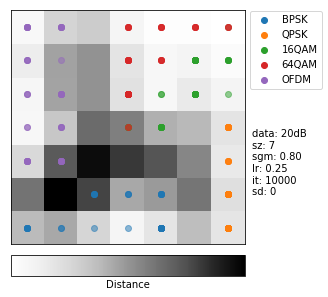

data: 20dB | sz: 11 | sgm: 0.60 | lr: 0.50 | it: 10000 | sd: 0


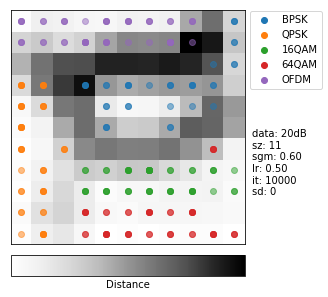

data: 20dB | sz: 15 | sgm: 1.40 | lr: 0.25 | it: 10000 | sd: 0


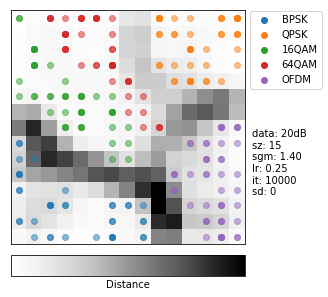

In [8]:
%matplotlib inline

train_som(*data_20, size=7, sigma=0.8, lr=0.25, iters=10000, seed=0)
train_som(*data_20, size=11, sigma=0.6, lr=0.5, iters=10000, seed=0)
train_som(*data_20, size=15, sigma=1.4, lr=0.25, iters=10000, seed=0)

# sample SOMs

<table>
    <tr>
        <td><img src ="./results/som/selection/data_20dB-sz_7-sgm_0.80-lr_0.25-it_10000-sd_0.png" width=300></td>
        <td><img src ="./results/som/selection/data_20dB-sz_11-sgm_0.60-lr_0.50-it_10000-sd_0.png" width=300></td>
        <td><img src ="./results/som/selection/data_20dB-sz_15-sgm_1.40-lr_0.25-it_10000-sd_0.png" width=300></td>
    </tr>
</table>